## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial kernel
x, c = shortestpath.genData(n+1000, p, grid, deg=deg)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.32it/s]


In [8]:
# get test data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.50it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# prediction model
reg = LinearRegression()

## Two-Stage

In [17]:
from twostage import sklearnPred
from evalm import calTrueSPO, calUnambSPO
import time
import numpy as np
from tqdm import tqdm

In [18]:
# build model
twostage_model = sklearnPred(reg, sp_model)

In [19]:
# training
twostage_model.fit(sp_dataset_train.x, sp_dataset_train.c)

In [20]:
# prediction
c_test_pred = twostage_model.predict(sp_dataset_test.x)

In [21]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = sp_dataset_test.c[i]
    z_true_i = sp_dataset_test.z[i,0]
    truespo += calTrueSPO(sp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += calUnambSPO(sp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / sp_dataset_test.z.sum() * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / sp_dataset_test.z.sum() * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.18it/s]


Normalized true SPO Loss: 1.74%
Normalized unambiguous SPO Loss: 1.74%


In [22]:
# compare solutions
import torch
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 150.81, 175.91, 82.00, 209.67, 124.63, 113.51, 79.93, 187.40, 268.03, 85.78, 113.51, 108.82, 222.78, 187.40, 105.66, 187.40, 155.32, 58.88, 137.62, 113.51, 108.82, 58.88, 92.49, 101.22, 116.20, 79.93, 105.66, 105.66, 180.55, 227.25, 63.94, 222.78, 63.94, 175.91, 82.00, 227.25, 79.93, 227.25, 128.53, 58.88
    Pred cost: 158.79, 180.54, 82.00, 207.86, 131.87, 141.00, 106.96, 201.75, 216.14, 103.57, 141.00, 123.14, 232.48, 201.75, 126.62, 201.75, 175.10, 67.11, 169.61, 141.00, 123.14, 67.11, 118.21, 107.76, 118.90, 106.96, 126.62, 126.62, 172.37, 185.28, 83.83, 232.48, 83.83, 180.54, 82.00, 185.28, 106.96, 185.28, 148.18, 67.11
    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, True obj: 759.22
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 759.22

Sample 1:
    True cost: 37.73, 33.34,

## Linear Regression from PyTorch

In [23]:
import torch
from torch import nn

In [24]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

In [25]:
from matplotlib import pyplot as plt
import numpy as np

In [26]:
from func import SPOPlus
from evalm import trueSPO, unambSPO

In [27]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [29]:
# init SPO+ loss
criterion = SPOPlus()

In [30]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 686.9929, True SPO Loss:  2.1044%, Unambiguous SPO Loss:  2.1044%
Epoch  20, Loss: 340.7765, True SPO Loss:  1.5707%, Unambiguous SPO Loss:  1.5707%
Epoch  30, Loss: 295.0736, True SPO Loss:  1.2063%, Unambiguous SPO Loss:  1.2063%
Epoch  40, Loss: 100.7952, True SPO Loss:  0.9177%, Unambiguous SPO Loss:  0.9177%
Epoch  50, Loss:  25.9722, True SPO Loss:  0.7349%, Unambiguous SPO Loss:  0.7349%
Epoch  60, Loss:  89.8412, True SPO Loss:  0.7092%, Unambiguous SPO Loss:  0.7092%
Epoch  70, Loss: 105.2432, True SPO Loss:  0.5598%, Unambiguous SPO Loss:  0.5598%
Epoch  80, Loss:   5.5486, True SPO Loss:  0.5881%, Unambiguous SPO Loss:  0.5881%
Epoch  90, Loss: 161.9812, True SPO Loss:  0.6002%, Unambiguous SPO Loss:  0.6002%
Epoch 100, Loss:  37.2305, True SPO Loss:  0.5096%, Unambiguous SPO Loss:  0.5096%
Epoch 110, Loss:  18.2937, True SPO Loss:  0.5084%, Unambiguous SPO Loss:  0.5084%
Epoch 120, Loss:  61.3193, True SPO Loss:  0.4673%, Unambiguous SPO Loss:  0.4673%
Epoc

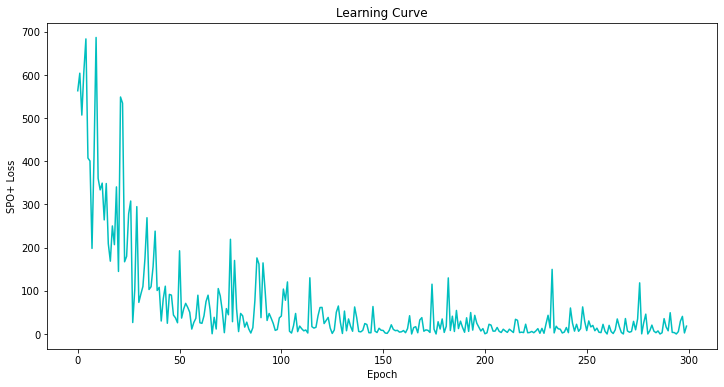

In [31]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

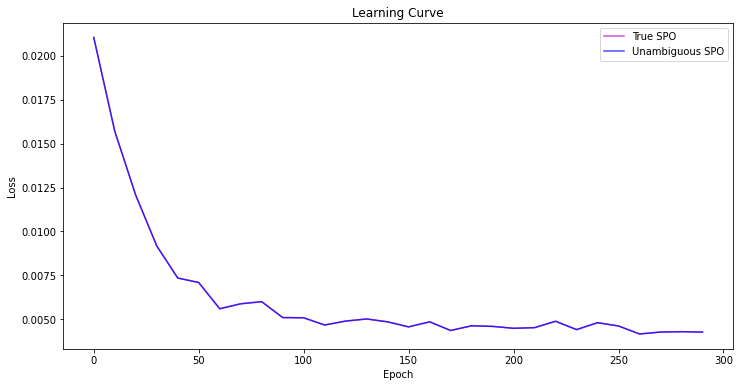

In [32]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [33]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.43%
Normalized unambiguous SPO Loss: 0.43%


In [34]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -76.63, -2.49, 14.04, 5.49, 78.35, -95.61, -21.85, 28.81, 4.65, 70.44, -19.20, -90.99, -25.42, 30.64, -17.97, 64.88, -75.07, -12.56, 38.09, -30.42, -32.56, -24.69, -4.78, 40.59, 42.54, -73.45, -21.96, 7.40, 39.34, 102.78, 19.96, -19.56, 17.35, -30.94, 20.05, 0.65, -19.95, -0.03, -31.86, 0.57
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27

##  SPO+ with Regularization

In [35]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [36]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [37]:
# init SPO+ loss
criterion = SPOPlus()

In [38]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 325.0947, True SPO Loss:  2.2976%, Unambiguous SPO Loss:  2.2976%
Epoch  20, Loss: 254.1456, True SPO Loss:  1.5361%, Unambiguous SPO Loss:  1.5361%
Epoch  30, Loss:  41.4917, True SPO Loss:  1.1413%, Unambiguous SPO Loss:  1.1413%
Epoch  40, Loss:  85.7301, True SPO Loss:  0.8305%, Unambiguous SPO Loss:  0.8305%
Epoch  50, Loss: 210.9615, True SPO Loss:  0.7604%, Unambiguous SPO Loss:  0.7604%
Epoch  60, Loss:  85.3835, True SPO Loss:  0.7336%, Unambiguous SPO Loss:  0.7336%
Epoch  70, Loss:  13.2928, True SPO Loss:  0.6272%, Unambiguous SPO Loss:  0.6272%
Epoch  80, Loss:  33.5210, True SPO Loss:  0.5472%, Unambiguous SPO Loss:  0.5472%
Epoch  90, Loss:  52.1071, True SPO Loss:  0.5454%, Unambiguous SPO Loss:  0.5454%
Epoch 100, Loss:  26.0443, True SPO Loss:  0.5167%, Unambiguous SPO Loss:  0.5167%
Epoch 110, Loss:   8.1902, True SPO Loss:  0.4700%, Unambiguous SPO Loss:  0.4700%
Epoch 120, Loss:  20.4499, True SPO Loss:  0.4876%, Unambiguous SPO Loss:  0.4876%
Epoc

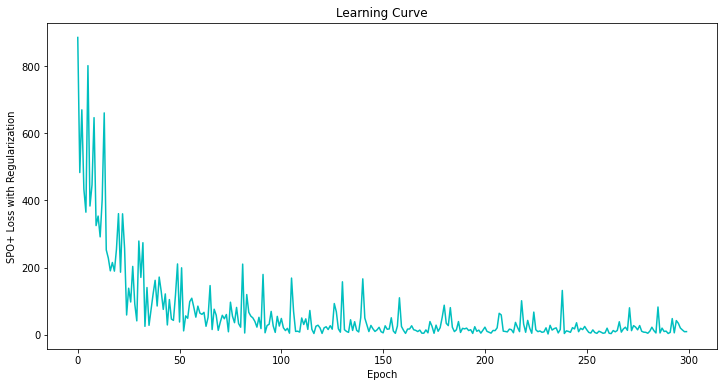

In [39]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

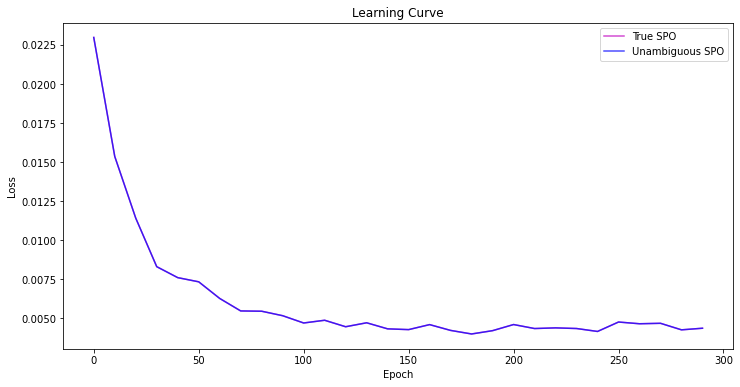

In [40]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [41]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.44%
Normalized unambiguous SPO Loss: 0.44%


In [42]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -75.73, -7.22, 12.30, -5.11, 75.74, -77.83, -18.67, 9.63, -0.75, 62.62, -13.98, -93.18, -39.42, 29.05, -19.29, 68.33, -79.73, -17.31, 31.96, -26.55, -30.14, -18.75, 1.29, 36.84, 52.13, -66.00, -27.95, 8.14, 38.11, 105.14, 24.21, -17.23, 17.53, -35.60, 27.45, 0.98, -19.99, 4.33, -33.75, 2.01
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 201.43

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27,

## Black-Box

In [43]:
from func import blackboxOpt

In [44]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [45]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-4)

In [46]:
# set loss
criterion = nn.L1Loss()

In [47]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = blackboxOpt.apply(sp_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 347.5916, True SPO Loss: 49.0112%, Unambiguous SPO Loss: 49.0112%
Epoch  20, Loss: 170.5317, True SPO Loss: 43.8196%, Unambiguous SPO Loss: 43.8196%
Epoch  30, Loss: 165.5135, True SPO Loss: 36.1535%, Unambiguous SPO Loss: 36.1535%
Epoch  40, Loss: 143.2910, True SPO Loss: 28.9831%, Unambiguous SPO Loss: 28.9831%
Epoch  50, Loss: 122.6700, True SPO Loss: 21.8296%, Unambiguous SPO Loss: 21.8296%
Epoch  60, Loss:  73.6820, True SPO Loss: 17.0517%, Unambiguous SPO Loss: 17.0517%
Epoch  70, Loss: 139.6243, True SPO Loss: 12.7550%, Unambiguous SPO Loss: 12.7550%
Epoch  80, Loss:  61.8554, True SPO Loss:  9.0969%, Unambiguous SPO Loss:  9.0969%
Epoch  90, Loss:  41.8742, True SPO Loss:  7.1005%, Unambiguous SPO Loss:  7.1005%
Epoch 100, Loss:  33.8030, True SPO Loss:  5.7707%, Unambiguous SPO Loss:  5.7707%
Epoch 110, Loss:   6.5182, True SPO Loss:  4.8955%, Unambiguous SPO Loss:  4.8955%
Epoch 120, Loss:  11.1784, True SPO Loss:  4.7354%, Unambiguous SPO Loss:  4.7354%
Epoc

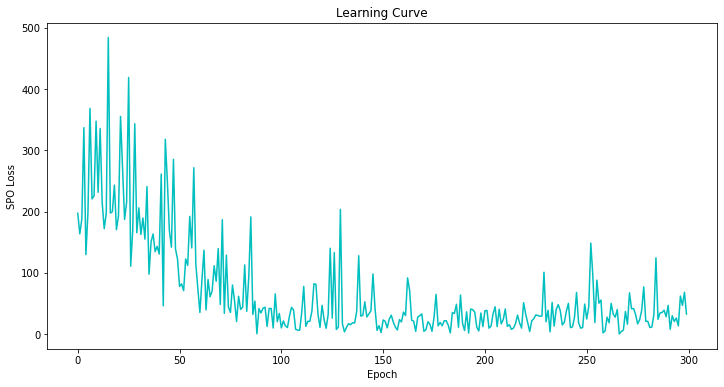

In [48]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

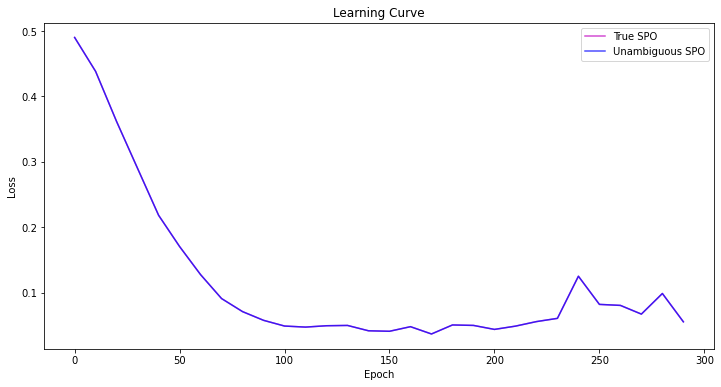

In [49]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [50]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 5.54%
Normalized unambiguous SPO Loss: 5.54%


In [51]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -0.12, 0.18, 0.22, 0.63, -0.08, 0.51, 0.67, 1.18, -0.24, 0.46, 0.34, 0.18, -0.23, 0.46, 0.05, -0.33, -0.62, 0.08, 0.06, -0.04, -0.11, 0.56, 0.13, -0.28, 0.19, -0.27, -0.52, -0.14, 0.42, -0.57, 0.22, -0.47, 0.41, -0.54, 0.65, 0.50, 0.48, -0.48, 0.62, 0.06
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 228.43

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24, 7.29, 55.24

## Black-Box with Regularization

In [52]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [53]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-4)

In [54]:
# set loss
criterion = nn.L1Loss()

In [55]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = blackboxOpt.apply(sp_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 321.3180, True SPO Loss: 35.3562%, Unambiguous SPO Loss: 35.3562%
Epoch  20, Loss: 188.6849, True SPO Loss: 30.6617%, Unambiguous SPO Loss: 30.6617%
Epoch  30, Loss: 152.3313, True SPO Loss: 23.4959%, Unambiguous SPO Loss: 23.4959%
Epoch  40, Loss:  96.7386, True SPO Loss: 18.9883%, Unambiguous SPO Loss: 18.9883%
Epoch  50, Loss:  64.4716, True SPO Loss: 15.1381%, Unambiguous SPO Loss: 15.1381%
Epoch  60, Loss: 112.9906, True SPO Loss: 12.3179%, Unambiguous SPO Loss: 12.3179%
Epoch  70, Loss:  88.2567, True SPO Loss:  9.8335%, Unambiguous SPO Loss:  9.8335%
Epoch  80, Loss:  31.0112, True SPO Loss:  7.9007%, Unambiguous SPO Loss:  7.9007%
Epoch  90, Loss:  67.2850, True SPO Loss:  6.5358%, Unambiguous SPO Loss:  6.5358%
Epoch 100, Loss:  40.1474, True SPO Loss:  5.4225%, Unambiguous SPO Loss:  5.4225%
Epoch 110, Loss:  42.2088, True SPO Loss:  4.7290%, Unambiguous SPO Loss:  4.7290%
Epoch 120, Loss:  49.5717, True SPO Loss:  4.2075%, Unambiguous SPO Loss:  4.2075%
Epoc

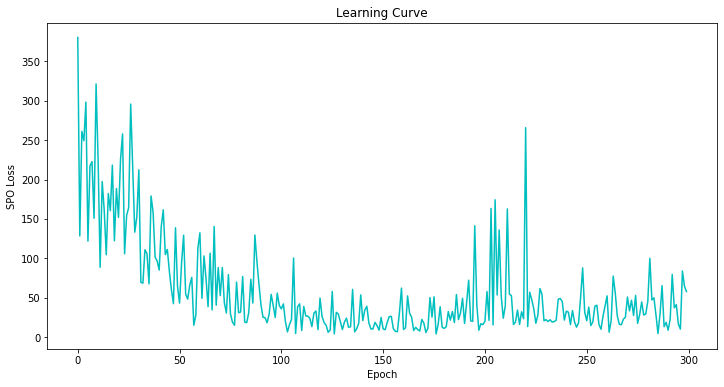

In [56]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

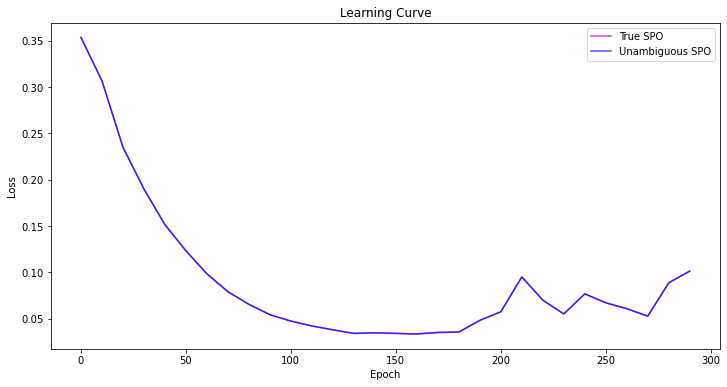

In [57]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [58]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 10.11%
Normalized unambiguous SPO Loss: 10.14%


In [59]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: 0.59, 0.20, -1.03, 0.10, 0.03, -0.07, 0.10, 0.90, 0.54, 0.49, 0.37, -0.47, 0.81, -0.09, -0.06, -0.81, -0.03, 0.59, 0.52, -0.38, 0.35, 0.56, -0.14, -0.92, -0.54, 0.07, -0.25, -0.25, -0.01, 0.96, 0.25, 0.12, 0.56, 0.66, -0.27, -0.50, 0.24, 0.29, 0.03, 0.01
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 228.43

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24, 7.29, 55.24